# Getting ready

## Preprocessing, etc.

In [2]:
from Bio import SeqIO
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import pysam
import copy
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

In [3]:
# Function for plotting anything related to chromsome loci.
sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/chm13_chromsome_sizes.txt', header=None)
sizes_df[0] = [int(i.replace('X', '23').replace('Y', '24').replace('M', '25').replace('chr', '')) for i in sizes_df[0]]
sizes_df = sizes_df.sort_values(0)
sizes = sizes_df[1]
starts_chrom = [np.sum(sizes[:i]) for i in range(25)]
#starts_chrom = [np.sum(sizes[:i]) for i in range(23)] + [3041559849,3041559849+1700]

def loci_linear_idx(chrom, loci):
    chrom=int(chrom)
    return starts_chrom[chrom-1]+loci

In [4]:
f, ax = plt.subplots(figsize=(20,.5))
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=.4, s=chrom, fontsize=9, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=.6, color=color, linestyle='-', linewidth=7)
plt.xlim(0,starts_chrom[-1]+1e8)
ax.axis('off')
plt.ylim(.4,.6)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/chrom_labels.svg', transparent=True)
plt.show()

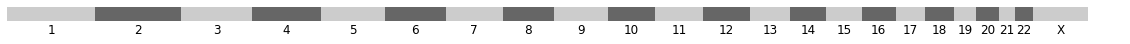

In [5]:
f, ax = plt.subplots(figsize=(20,.5))
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=0, s=chrom, fontsize=12, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=.5, color=color, linestyle='-', linewidth=20)
plt.xlim(0,starts_chrom[-1]+1e8)
ax.axis('off')
plt.ylim(0,.6)
#plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/chrom_labels_thick.svg', transparent=True)
plt.show()

### Ids of medium prevalence k-mers.

In [6]:
prevs = np.loadtxt('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/counts/unmapped_prevs.txt')
good_prevs_ids = np.where((prevs>.2)&(prevs<.8))[0]
good_prevs_ids = set(good_prevs_ids)

## Filtering Localizations.

In [7]:
### Y CHROMSOME ####
localized_starts = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_start_with_Y.bed', header=None, index_col=3) 
localized_ends = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_end_with_Y.bed', header=None, index_col=3)

idxs = good_prevs_ids.intersection(localized_starts.index).intersection(localized_ends.index)

localized_starts = localized_starts.loc[idxs]
localized_ends = localized_ends.loc[idxs]

localized = localized_starts
localized.columns = ['chrom_start', 'loc_start', 'loc_end']
localized['loc_end'] = localized_ends[1]
localized['chrom_end'] = localized_ends[0]
localized = localized[localized['chrom_start']==localized['chrom_end']].drop('chrom_end', axis=1)
localized.columns = ['chrom', 'start', 'end']
localized['prev'] = prevs[localized.index]

localized_Y = copy.deepcopy(localized)
localized_Y = localized_Y[localized_Y['chrom']=='chr24']
localized_hg38 = copy.deepcopy(localized)

print(len(localized[localized.chrom!='chr24']), 'number localized')
print(np.median(localized[localized.chrom!='chr24'].end-localized[localized.chrom!='chr24'].start), 'median localization region length (HG38 coords)')

/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1716471 number localized
5249036.0 median localization region length (HG38 coords)


## Read in autosomes

In [8]:
localized = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_regions_T2T.bed', header=None, index_col=3, usecols=[0,1,2,3])
localized.columns = ['chrom', 'start', 'end']
localized['prev'] = prevs[localized.index]
localized= localized[(localized.prev>.2) & (localized.prev<.8)]

## Read in T2T alignments.

In [9]:
#%%bash
# Copy over first ~1 million T2T alignments so that we don't have to read in the whole file.
#cd /home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/
#samtools view -F 2304 -h kmers_unmapped_filt_t2t_aligned.sam  | head -n 104565882 > kmers_unmapped_filt_t2t_aligned_smaller.sam

In [10]:
# Load unmapped read alignments to CHM13.
samfile = pysam.AlignmentFile("/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_smaller.sam", "r")
reads = [f for i,f in enumerate(samfile.fetch()) if i in good_prevs_ids]

In [11]:
metrics_old = [(int(x.query_name),x.reference_name, 
            0 if (x.reference_start is None) or (x.reference_end is None) else (x.reference_start+x.reference_end)/2,
            True if 'XA' in [i[0] for i in x.get_tags()] else False,
            x.get_tag('AS')) for x in reads]
    
metrics_old = pd.DataFrame(metrics_old)
metrics_old.index = [int(i) for i in metrics_old[0]]

metrics_old['prev'] = prevs[metrics_old.index]
not_aligned = metrics_old[pd.isnull(metrics_old[1])]
metrics_old = metrics_old[~pd.isnull(metrics_old[1])]
metrics_old['chrom']= [int(i.replace('chr', '').replace('X', '23').replace('Y', '24').replace('M', '25')) if i else None for i in metrics_old[1]]

In [12]:
print(len(metrics_old))
print(len(not_aligned))

2546103
31679


## Comparing localization & alignments.

### Localized but not aligned to T2T

In [13]:
localized_but_not_aligned = sorted(set(localized_hg38.index).intersection(not_aligned.index))
print(len(localized_but_not_aligned)/len(not_aligned), ' of unaligned T2T (.2-.8 prev) was localized (including Y)')

localized_but_not_aligned = sorted(set(localized_Y.index).intersection(not_aligned.index))
print(len(localized_but_not_aligned)/len(not_aligned), ' of unaligned T2T (.2-.8 prev) was localized to Y-chromsome')

localized_but_not_aligned = sorted(set(localized.index).intersection(not_aligned.index))
print(len(localized_but_not_aligned)/len(not_aligned), ' of unaligned T2T (.2-.8 prev) was localized to autosomes')
localized_but_not_aligned = localized.loc[localized_but_not_aligned]

0.8848132832475772  of unaligned T2T (.2-.8 prev) was localized (including Y)
0.31389879731052117  of unaligned T2T (.2-.8 prev) was localized to Y-chromsome
0.5346444016540927  of unaligned T2T (.2-.8 prev) was localized to autosomes


In [14]:
missing_from_t2t = sorted(set(localized.index).difference(metrics_old.index))
print(len(missing_from_t2t)/len(localized), 'missing from T2T')

0.015452804487398808 missing from T2T


In [15]:
localized_missing_from_t2t = localized.loc[missing_from_t2t]

In [16]:
localized_missing_from_t2t_linear_id =[loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    localized_missing_from_t2t['chrom'],
    (localized_missing_from_t2t['start']+localized_missing_from_t2t['end'])/2)]



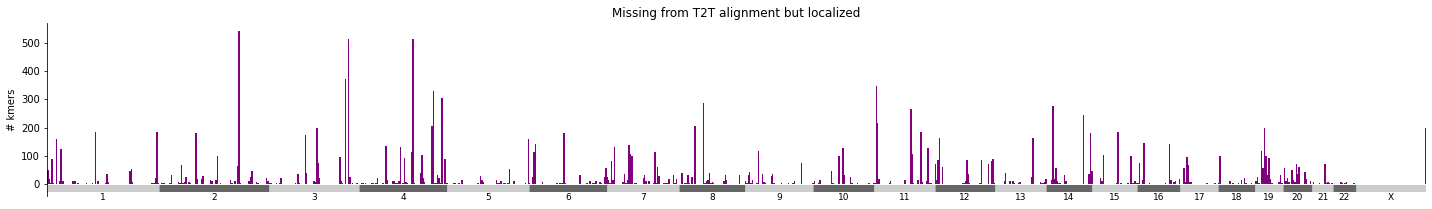

In [17]:
f, ax = plt.subplots(figsize=(20,3))
plt.hist(localized_missing_from_t2t_linear_id, bins=1000, color='purple')
ax.set_xlabel('ASLAN localization')
ax.set_ylabel('# kmers')
ax.set_title('Missing from T2T alignment but localized')
plt.xlim(0,starts_chrom[23]-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.xaxis.set_visible(False)
#plt.yscale('log')
#plt.ylim(.07,)


for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=-55, s=chrom, fontsize=9, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=-15, color=color, linestyle='-', linewidth=7)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_genetic_variation/missing_from_t2t_genetic_variation.svg', transparent=True)
plt.show()

### Analyze where these hotspots are coming from for results text.

In [22]:
for i in range(1,24):
    print(i)
    print(
        Counter(np.round(localized_missing_from_t2t[localized_missing_from_t2t.chrom==('chr%i' % i)].start, -5)).most_common(10))
    print(
        Counter(np.round(localized_missing_from_t2t[localized_missing_from_t2t.chrom==('chr%i' % i)].end, -5)).most_common(10))

1
[(19500000, 151), (244100000, 133), (107600000, 110), (29300000, 49), (182000000, 40), (12100000, 39), (107500000, 31), (186200000, 28), (29200000, 27), (243800000, 23)]
[(19600000, 143), (108000000, 76), (244600000, 75), (30100000, 67), (12300000, 63), (244400000, 44), (244500000, 43), (108600000, 43), (183200000, 41), (30200000, 40)]
2
[(175200000, 162), (175300000, 134), (80500000, 98), (175700000, 90), (174500000, 57), (127400000, 54), (81400000, 44), (174800000, 40), (174600000, 24), (80000000, 21)]
[(176800000, 85), (176700000, 71), (84100000, 65), (177600000, 62), (84700000, 54), (177200000, 51), (128700000, 45), (177000000, 45), (84900000, 37), (176600000, 35)]
3
[(170600000, 267), (177300000, 230), (176500000, 101), (177400000, 96), (79400000, 81), (104900000, 72), (157900000, 62), (104700000, 44), (104800000, 37), (110200000, 36)]
[(177800000, 169), (171300000, 168), (106700000, 153), (171000000, 130), (84100000, 102), (178100000, 93), (177900000, 65), (112000000, 64), (840

### Agreement / Accuracy
Look at which agree with T2T, stratified by alignment score & whether it has alt. alignments.


In [23]:
idxs = sorted(set(localized.index).intersection(metrics_old.index))
metrics = metrics_old.loc[idxs]
localized = localized.loc[idxs]

In [24]:
comparison = copy.deepcopy(metrics)#.sample(len(metrics), replace=True)
comparison.columns = ['idx', 'chrom_aligned', 'start_aligned', 'mult_alignments', 'AS', 'prev', 'chrom']
comparison['chrom_localized'] = localized['chrom'].values
comparison['start_localized'] = localized['start'].values
comparison['end_localized'] = localized['end'].values


correctly_localized = comparison[(comparison['start_aligned']>=comparison['start_localized']) &
              (comparison['start_aligned']<=comparison['end_localized']) & (
                  comparison['chrom_localized']==comparison['chrom_aligned'])]
incorrectly_localized = comparison[~((comparison['start_aligned']>=comparison['start_localized']) &
              (comparison['start_aligned']<=comparison['end_localized']) & (
                  comparison['chrom_localized']==comparison['chrom_aligned']))]
incorrectly_chrom_localized = comparison[comparison['chrom_localized']!=comparison['chrom_aligned']]

comparison['is_same_chrom'] = comparison['chrom_localized']==comparison['chrom_aligned']
comparison['is_same_loc'] = False
comparison.loc[correctly_localized.index,'is_same_loc'] = True


print((len(comparison)-len(incorrectly_chrom_localized))/len(comparison), 'localized to right chrom')
print(len(correctly_localized)/(len(correctly_localized)+len(incorrectly_localized)), 'localized fully correctly')
print(len(correctly_localized)/(len(comparison)-len(incorrectly_chrom_localized)), 'localized correctly/localized chrom correctly')

0.6897934408911047 localized to right chrom
0.41662017773906274 localized fully correctly
0.6039781665665811 localized correctly/localized chrom correctly


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


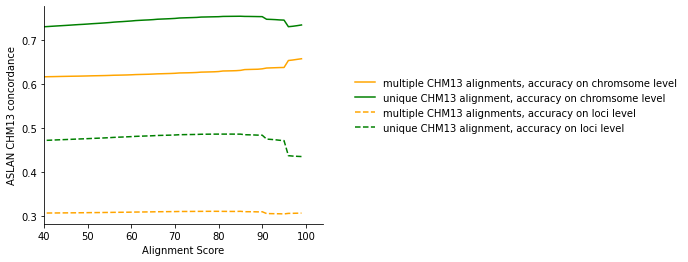

In [25]:
comparison_filt = copy.deepcopy(comparison[comparison['mult_alignments']==True])

accuracy = [0 for i in range(100)]
for i in range(100):
    comparison_filt = comparison_filt[comparison_filt.AS>=i]
    accuracy[i] = np.mean(comparison_filt['is_same_chrom'])#/np.mean(metrics_filt[1].values==localized_filt['chrom'].values)

    
comparison_filt = copy.deepcopy(comparison[comparison['mult_alignments']==False])
accuracy2 = [0 for i in range(100)]
for i in range(100):
    comparison_filt = comparison_filt[comparison_filt.AS>=i]
    accuracy2[i] = np.mean(comparison_filt['is_same_chrom'])#/np.mean(metrics_filt[1].values==localized_filt['chrom'].values)
    
    
comparison_filt = copy.deepcopy(comparison[comparison['mult_alignments']==True])

accuracy3 = [0 for i in range(100)]
for i in range(100):
    comparison_filt = comparison_filt[comparison_filt.AS>=i]
    accuracy3[i] = np.mean(comparison_filt['is_same_loc'])#/np.mean(comparison_filt['is_same_chrom'])

    
comparison_filt = copy.deepcopy(comparison[comparison['mult_alignments']==False])
accuracy4 = [0 for i in range(100)]
for i in range(100):
    comparison_filt = comparison_filt[comparison_filt.AS>=i]
    accuracy4[i] = np.mean(comparison_filt['is_same_loc'])#/np.mean(comparison_filt['is_same_chrom'])#/np.mean(metrics_filt[1].values==localized_filt['chrom'].values)
    
    
f, ax = plt.subplots(figsize=(5,4))
plt.plot(accuracy, color='orange', linestyle='solid')
plt.plot(accuracy2, 'g-')
plt.plot(accuracy3, color='orange', linestyle='dashed')
plt.plot(accuracy4, 'g--')
plt.xlim(40,)
plt.legend(['multiple CHM13 alignments, accuracy on chromsome level',
            'unique CHM13 alignment, accuracy on chromsome level',
            'multiple CHM13 alignments, accuracy on loci level',
            'unique CHM13 alignment, accuracy on loci level'], loc=[1.1,.4], frameon=False)
ax.set_ylabel('ASLAN CHM13 concordance')
ax.set_xlabel('Alignment Score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/agreement_vs_AS.svg', transparent=True)
plt.show()


# Alignment Scores Distribution of concodrant vs disoncordant seqs

In [26]:
print((len(comparison)-len(incorrectly_chrom_localized))/len(comparison), 'localized to right chrom')
print(len(correctly_localized)/(len(correctly_localized)+len(incorrectly_localized)), 'localized fully correctly')
print(len(correctly_localized)/(len(comparison)-len(incorrectly_chrom_localized)), 'localized correctly/localized chrom correctly')

0.6897934408911047 localized to right chrom
0.41662017773906274 localized fully correctly
0.6039781665665811 localized correctly/localized chrom correctly


/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:836: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **artist_kws,


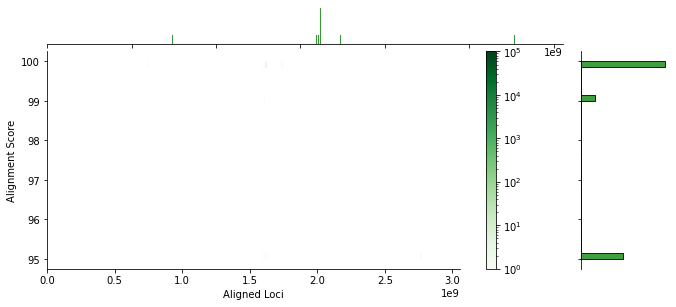

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:836: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **artist_kws,


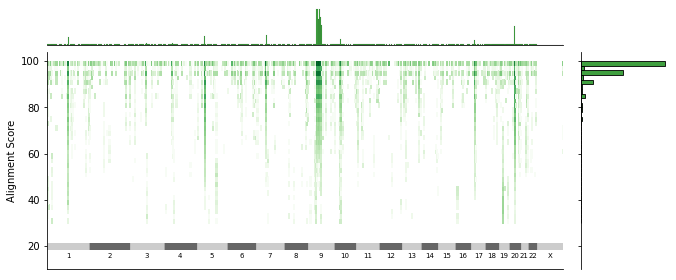

/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/distributions.py:836: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **artist_kws,


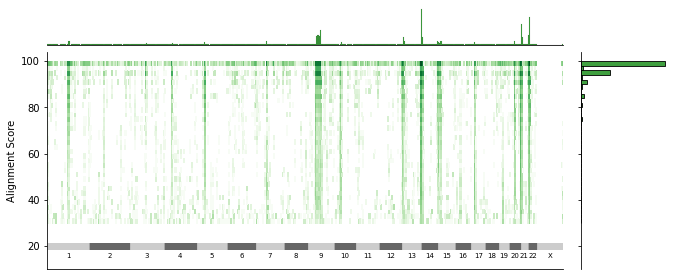

In [27]:
correctly_localized_linear_id = [loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    correctly_localized['chrom_aligned'],
    correctly_localized['start_aligned'])]
jp = sns.jointplot(x=correctly_localized_linear_id[:10],y=correctly_localized['AS'].iloc[:10], kind='hist', norm=LogNorm(), 
                   bins=(500,35), height=6, vmin=1, vmax=1e5,  color='green', cmap='Greens', cbar=True,cbar_kws = dict(use_gridspec=False,location='right'))
jp.fig.set_figwidth(10)
jp.fig.set_figheight(4)
plt.xlabel('Aligned Loci')
plt.ylabel('Alignment Score')
plt.xlim(0,starts_chrom[23]-1)
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_genetic_variation/loci_vs_alignment_score_color_bar.svg', transparent=True)
plt.show()

correctly_localized_linear_id = [loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    correctly_localized['chrom_aligned'],
    correctly_localized['start_aligned'])]
jp = sns.jointplot(x=correctly_localized_linear_id,y=correctly_localized['AS'], kind='hist', norm=LogNorm(), 
                   bins=(500,35), height=6, vmin=1, vmax=1e5,  color='green', cmap='Greens')
jp.fig.set_figwidth(10)
jp.fig.set_figheight(4)
plt.ylabel('Alignment Score')
plt.xlim(0,starts_chrom[23]-1)
jp.ax_joint.set_xticks([])

# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=15, s=chrom, fontsize=7, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=20, color=color, linestyle='-', linewidth=7)
plt.ylim(10,)
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_genetic_variation/loci_vs_alignment_score_correct.svg', transparent=True)
plt.show()

incorrectly_localized_linear_id = [loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    incorrectly_localized['chrom_aligned'],
    incorrectly_localized['start_aligned'])]
jp = sns.jointplot(x=incorrectly_localized_linear_id,y=incorrectly_localized['AS'], kind='hist', norm=LogNorm(), 
                   bins=(500,35), height=6, vmin=1, vmax=1e5,  color='green', cmap='Greens')
jp.fig.set_figwidth(10)
jp.fig.set_figheight(4)
plt.ylabel('Alignment Score')
plt.xlim(0,starts_chrom[23]-1)
jp.ax_joint.set_xticks([])

# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=15, s=chrom, fontsize=7, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=20, color=color, linestyle='-', linewidth=7)
plt.ylim(10,)


plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_genetic_variation/loci_vs_alignment_score_incorrect.svg', transparent=True)
plt.show()

# Setting up comparison dataframe

In [28]:
# Getting location of gaps in the hg38, using T2T coordinate system. 
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_t2t_aligned = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/gaps_hg38_t2t_aligned_starts.bed', header=None)
gaps_t2t_aligned.index = gaps_t2t_aligned[3]
gaps_df = gaps_df.loc[gaps_t2t_aligned.index]
gaps_t2t_aligned = gaps_t2t_aligned[gaps_df['type']=='N']
gaps_t2t_aligned.columns = ['chrom', 'start', 'stop', 'idx']
gaps_t2t_aligned['chrom'] = [c.replace('chr', '') for c in gaps_t2t_aligned['chrom'] ]

In [29]:
comparison['chrom_aligned'] = pd.Categorical([str(i).replace('chr', '').replace('24', 'Y').replace('23', 'X') for i in comparison['chrom_aligned']], categories=[str(i) for i in range(1,23)] + [
    'X', 'Y', 'M'], ordered=True)
comparison['chrom_localized'] = pd.Categorical([str(i).replace('chr', '').replace('24', 'Y').replace('23', 'X') for i in comparison['chrom_localized']],
                                               categories=[str(i) for i in range(1,23)] + ['X', 'Y', 'M'], ordered=True)
comparison['is_same_chrom'] = comparison['chrom_localized']==comparison['chrom_aligned']
comparison['is_same_loc'] = False
comparison.loc[correctly_localized.index,'is_same_loc'] = True


# Genetic Diversity
comparison['loci_correct'] = ((comparison['start_aligned']>=comparison['start_localized']) &
              (comparison['start_aligned']<=comparison['end_localized']) & (
                  comparison['chrom_localized']==comparison['chrom_aligned']))
comparison['chrom_correct'] = (comparison['chrom_localized']==comparison['chrom_aligned'])

# In agreement but low alignment score - high genetic diversity?

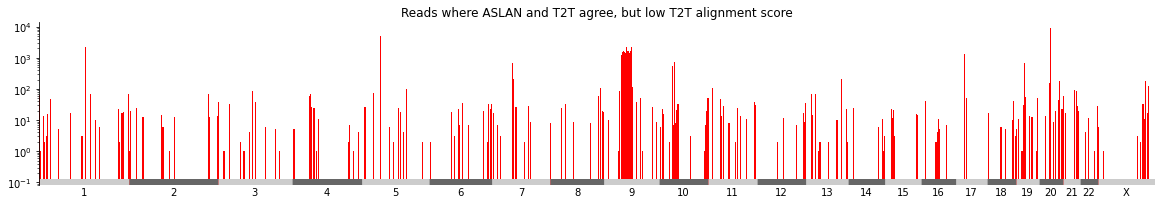

In [30]:
# Places with genetic diversity not captured on the T2T
A = comparison[(comparison.loci_correct) & (comparison.AS<90)]
f,ax = plt.subplots(figsize=(20,3))
plt.hist([loci_linear_idx(chrom.replace('X', '23'), loci) for chrom, loci in zip(A.chrom_aligned, A.start_aligned)], bins=1000, color='red')
ax.set_title('Reads where ASLAN and T2T agree, but low T2T alignment score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(0,starts_chrom[23]-1)
plt.yscale('log')
plt.xticks([])
ax.spines['bottom'].set_visible(False)
plt.ylim(.08,)

# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=.04, s=chrom, fontsize=10, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=.1, color=color, linestyle='-', linewidth=7)


plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_genetic_variation/agreement_low_AS.svg', transparent=True)
plt.show()

## Analyze where these hotspots are coming from for results text.

In [37]:
in_agreement_low_AS = A
for i in range(1,24):
    print(i)
    print(
        Counter(np.round(in_agreement_low_AS[in_agreement_low_AS.chrom_aligned==('%i' % i)].start_aligned, -4)).most_common(10))

1
[(127570000.0, 307), (127590000.0, 283), (127560000.0, 251), (127580000.0, 245), (127710000.0, 161), (127600000.0, 158), (245220000.0, 67), (127540000.0, 66), (128680000.0, 61), (127700000.0, 54)]
2
[(216870000.0, 50), (19820000.0, 24), (3060000.0, 18), (216860000.0, 18), (240130000.0, 14), (36190000.0, 13), (218570000.0, 13), (121460000.0, 13), (89370000.0, 8), (90380000.0, 6)]
3
[(1020000.0, 38), (95460000.0, 37), (32950000.0, 26), (100840000.0, 24), (100860000.0, 14), (95490000.0, 10), (95520000.0, 8), (95480000.0, 7), (95510000.0, 7), (95470000.0, 6)]
4
[(61350000.0, 24), (54920000.0, 19), (49570000.0, 16), (73750000.0, 11), (51010000.0, 10), (49610000.0, 10), (158680000.0, 7), (49580000.0, 7), (49540000.0, 6), (7360000.0, 5)]
5
[(49620000.0, 735), (49810000.0, 473), (49800000.0, 402), (49900000.0, 349), (49780000.0, 314), (49880000.0, 213), (49890000.0, 209), (49640000.0, 208), (49870000.0, 187), (49790000.0, 175)]
6
[(92180000.0, 35), (161550000.0, 32), (81110000.0, 22), (16894

# Disagreement Comparison

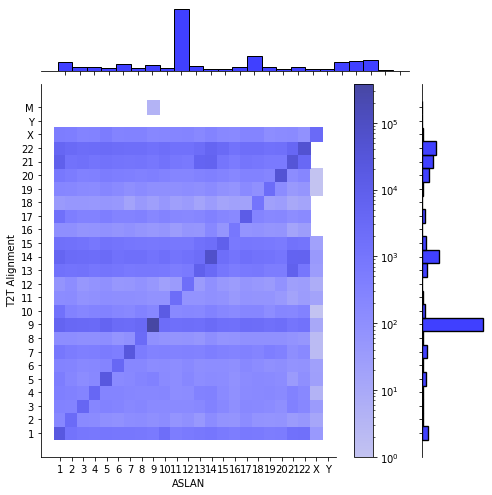

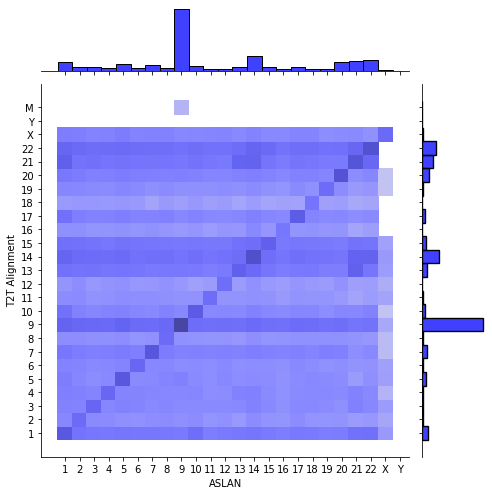

In [23]:
g = sns.jointplot(x=comparison['chrom_localized'], y=comparison['chrom_aligned'], kind='hist',
                  norm=LogNorm(), vmin=None, vmax=None,height=7, color='blue', cbar=True)
g.fig.axes[0].invert_yaxis()
plt.xlabel('ASLAN')
plt.ylabel('T2T Alignment')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/chrom_confusion_mat_cbar.svg', transparent=True)
plt.show()


g = sns.jointplot(x=comparison['chrom_localized'], y=comparison['chrom_aligned'], kind='hist', norm=LogNorm(), vmin=None, vmax=None,height=7, color='blue')
g.fig.axes[0].invert_yaxis()
plt.xlabel('ASLAN')
plt.ylabel('T2T Alignment')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/chrom_confusion_mat.svg', transparent=True)
plt.show()

In [28]:
# Coloring by alignment score
def MakeComparisonPlot(plot_function, file_dir=None):

    f, axes = plt.subplots(ncols=6, nrows=4, figsize=(30,22))
    for ax_i, chrom in enumerate([str(ch) for ch in range(1,23)]+['X']):
        current_slice = comparison[(comparison['chrom_aligned']==chrom) & (comparison['chrom_localized']==chrom)]
        if len(current_slice)==0: continue
        loci_aligned = current_slice.start_aligned
        loci_localized = (current_slice.start_localized+current_slice.end_localized)/2
        gaps_df_local = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
        gaps_df_local.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df_local.chrom]
        max_val = max([max(loci_aligned), max(loci_localized)])
        ax = axes[int(np.floor(ax_i/6)),ax_i%6]
        if False:
            for start, stop, chrom in zip(gaps_df_local.start, gaps_df_local.stop, gaps_df_local.chrom):
                r = Rectangle(xy=(start+0*loci_linear_idx(chrom.replace('chr', ''), start), 0),
                              height=max_val, width=stop-start, color='grey', alpha=.5)
                r1 = Rectangle(xy=(0,start+0*loci_linear_idx(chrom.replace('chr', ''), start)),
                            width=max_val, height=stop-start, color='grey', alpha=.5)
                ax.add_patch(r)
                ax.add_patch(r1)
        red_patch = mpatches.Patch(color='red')
        blue_patch = mpatches.Patch(color='blue')
        grey_patch = mpatches.Patch(color='grey')
        plot_function(ax, loci_localized, loci_aligned, current_slice)
        plt.plot()
        ax.set_ylim(0,max_val)
        ax.set_xlim(0,max_val)
        if ax_i==0:
            ax.set_ylabel('T2T Alignment')
            ax.set_xlabel('Pred')
        else: 
            ax.set_ylabel('')
            ax.set_xlabel('')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title('chr' + chrom)
        print('chr', chrom, np.mean((current_slice['start_aligned']>=current_slice['start_localized']) &
                                    (current_slice['start_aligned']<=current_slice['end_localized'])), 'localized the same')

    plt.savefig(file_dir, transparent=True)
    plt.show()


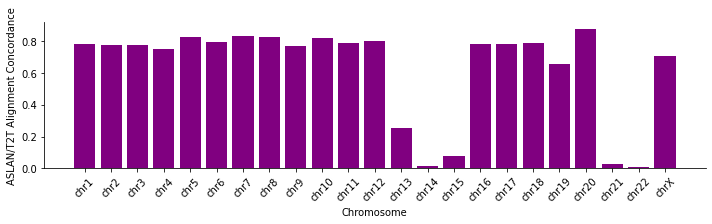

In [25]:
chrom_accuracy = dict({
'chr1': 0.7813723284589427,
'chr2': 0.7731497418244406,
'chr3': 0.7763074984247007,
'chr4': 0.751086431675519 ,
'chr5': 0.824075609351683 ,
'chr6': 0.7928170046420718,
'chr7': 0.8321526294088983,
'chr8': 0.8247832369942196,
'chr9': 0.7708929838095879,
'chr10':  0.820255583422906,
'chr11':  0.788685524126455,
'chr12':  0.797730636408485,
'chr13':  0.254783484390735,
'chr14':  0.012742374614757,
'chr15':  0.077179404493174,
'chr16':  0.781859931113662,
'chr17':  0.778808804488562,
'chr18': 0.7860824742268041,
'chr19': 0.6573705179282868,
'chr20': 0.8733678523187753,
'chr21': 0.03003919299260857,
'chr22': 0.009518366703452625,
'chrX': 0.7076356329537843})
f, ax = plt.subplots(figsize=(10,3))
plt.bar(x=chrom_accuracy.keys(), height=chrom_accuracy.values(), color='purple')
ax.set_xlabel('Chromosome')
ax.set_ylabel('ASLAN/T2T Alignment Concordance')
plt.xticks(rotation = 45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/chromsome_accuracies.svg', transparent=True)
plt.show()

chr 1 0.7813723284589427 localized the same
chr 2 0.7731497418244406 localized the same
chr 3 0.7763074984247007 localized the same
chr 4 0.751086431675519 localized the same
chr 5 0.824075609351683 localized the same
chr 6 0.7928170046420718 localized the same
chr 7 0.8321526294088983 localized the same
chr 8 0.8247832369942196 localized the same
chr 9 0.7708929838095879 localized the same
chr 10 0.8202555834229069 localized the same
chr 11 0.7886855241264559 localized the same
chr 12 0.7977306364084854 localized the same
chr 13 0.25478348439073517 localized the same
chr 14 0.012742374614757383 localized the same
chr 15 0.07717940449317424 localized the same
chr 16 0.7818599311136625 localized the same
chr 17 0.7788088044885628 localized the same
chr 18 0.7860824742268041 localized the same
chr 19 0.6573705179282868 localized the same
chr 20 0.8733678523187753 localized the same
chr 21 0.03003919299260857 localized the same
chr 22 0.009518366703452625 localized the same
chr X 0.707635

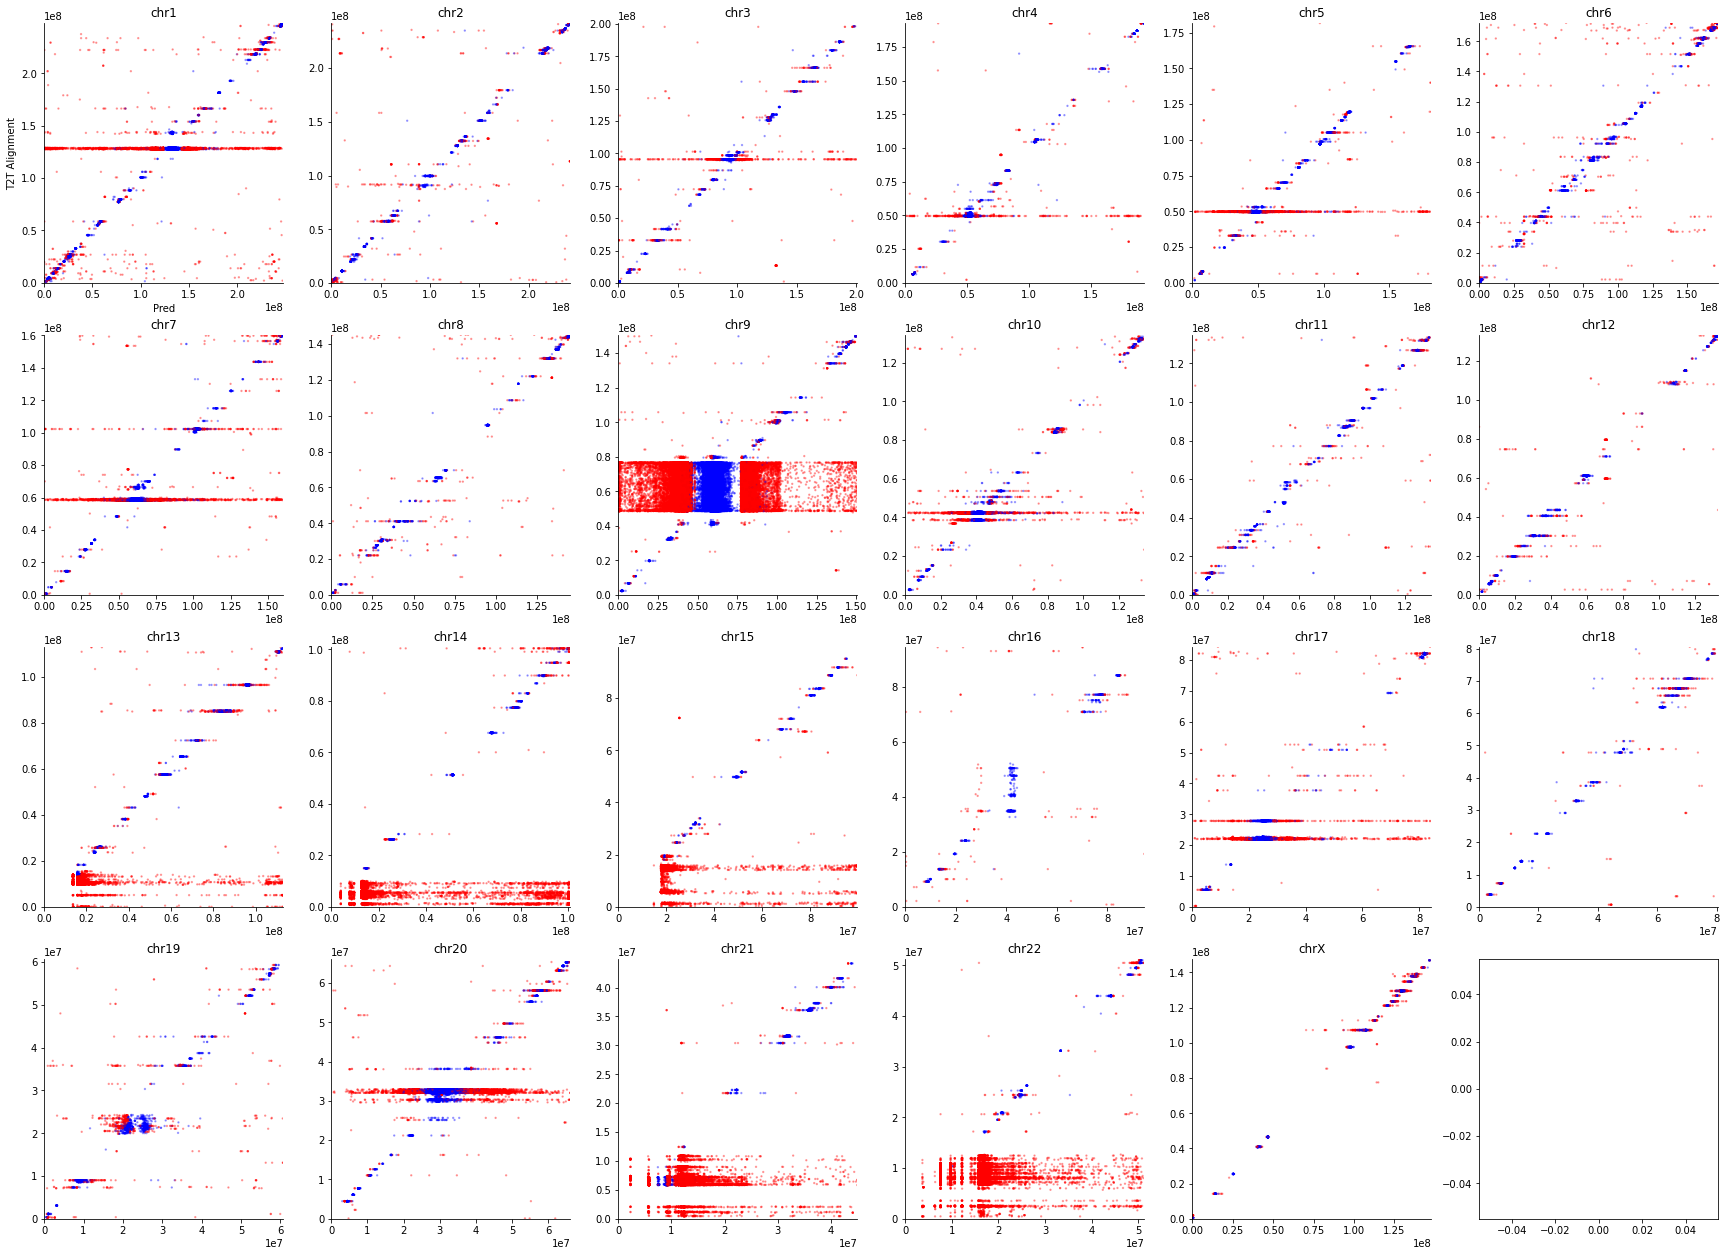

In [26]:
file_dir='/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/localized_vs_aligned_colored_by_is_correct.svg'
def color_by_is_same_loc(ax, loci_localized,loci_aligned, current_slice):
    ax.scatter(loci_localized, loci_aligned, c=~current_slice['is_same_loc'], s=2, alpha=.3, cmap='bwr', vmin=0, vmax=1)

MakeComparisonPlot(plot_function=color_by_is_same_loc, file_dir=file_dir)

chr 1 0.7813723284589427 localized the same
chr 2 0.7731497418244406 localized the same
chr 3 0.7763074984247007 localized the same
chr 4 0.751086431675519 localized the same
chr 5 0.824075609351683 localized the same
chr 6 0.7928170046420718 localized the same
chr 7 0.8321526294088983 localized the same
chr 8 0.8247832369942196 localized the same
chr 9 0.7708929838095879 localized the same
chr 10 0.8202555834229069 localized the same
chr 11 0.7886855241264559 localized the same
chr 12 0.7977306364084854 localized the same
chr 13 0.25478348439073517 localized the same
chr 14 0.012742374614757383 localized the same
chr 15 0.07717940449317424 localized the same
chr 16 0.7818599311136625 localized the same
chr 17 0.7788088044885628 localized the same
chr 18 0.7860824742268041 localized the same
chr 19 0.6573705179282868 localized the same
chr 20 0.8733678523187753 localized the same
chr 21 0.03003919299260857 localized the same
chr 22 0.009518366703452625 localized the same
chr X 0.707635

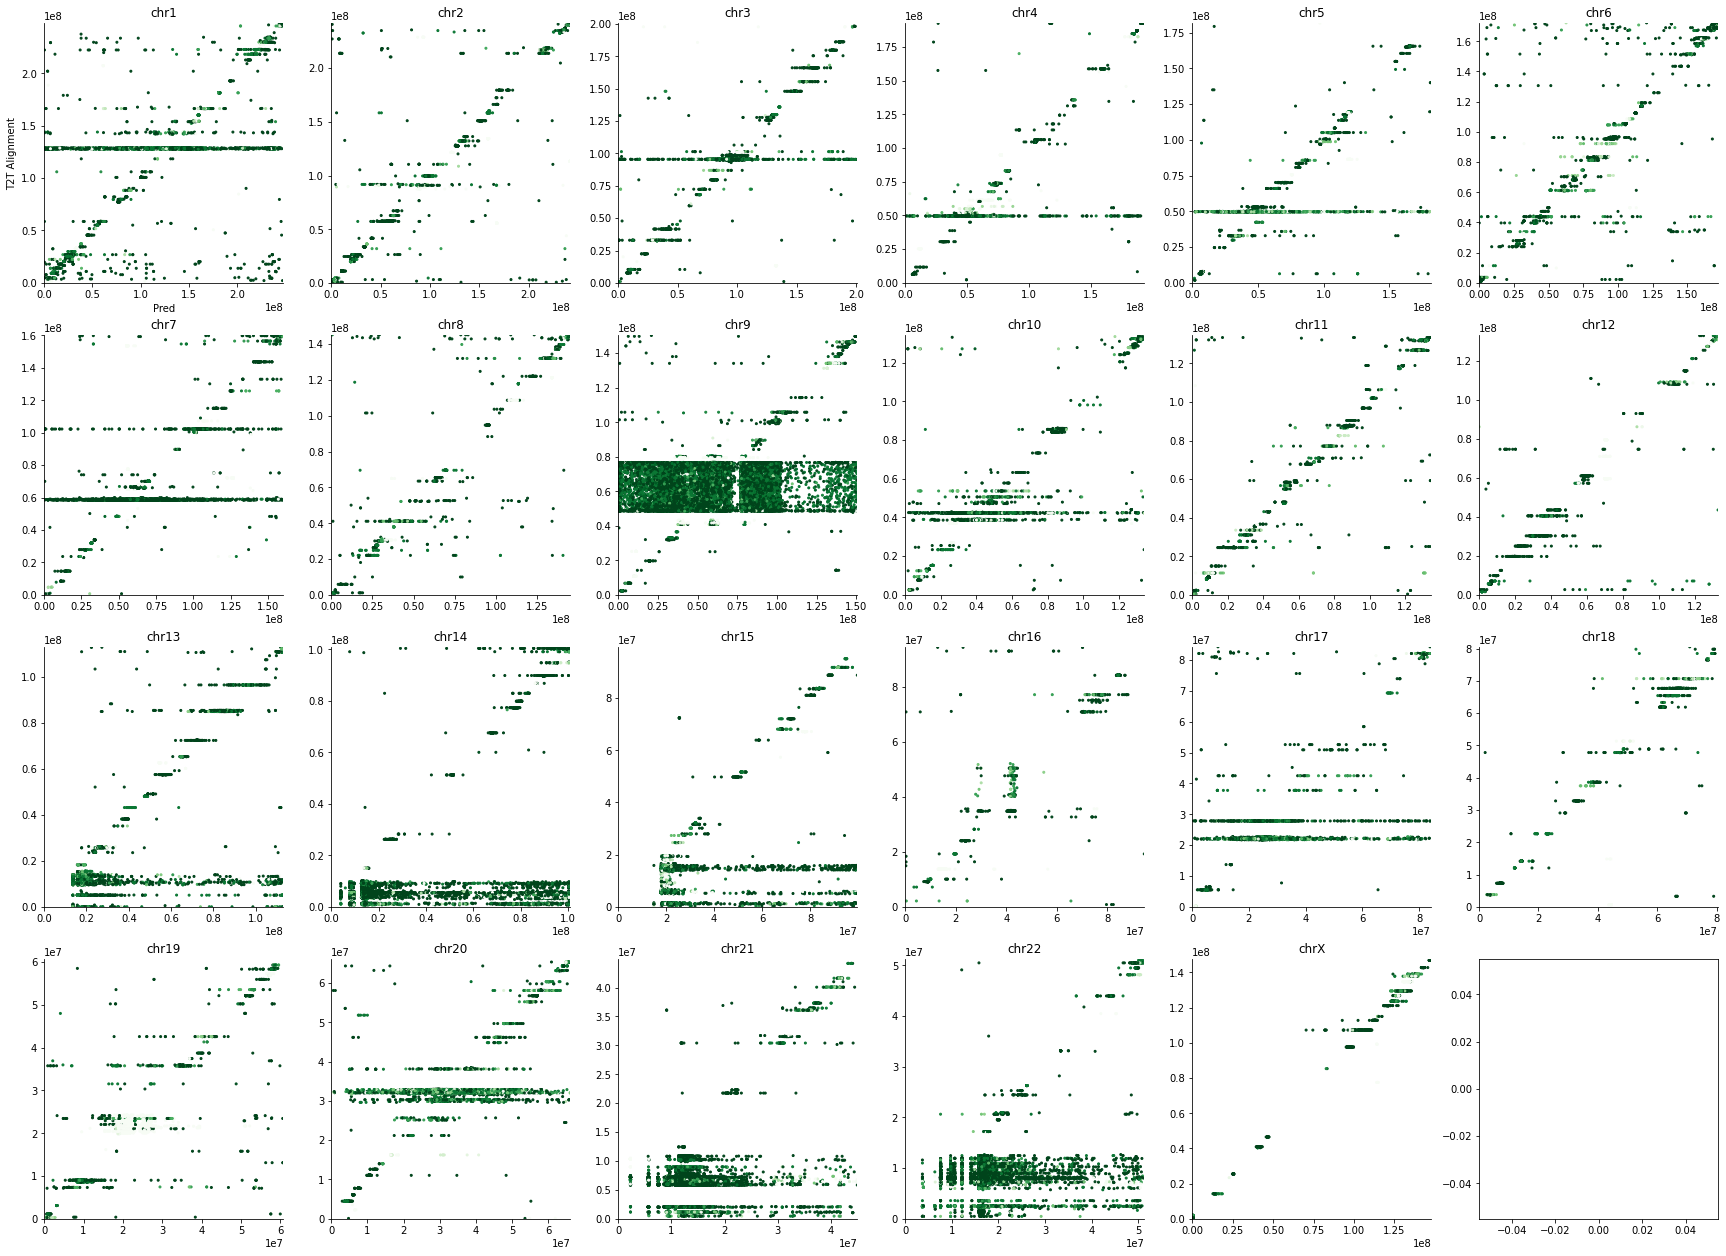

In [33]:
file_dir='/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/localized_vs_aligned_colored_by_AS.svg'
def color_by_AS(ax, loci_localized,loci_aligned, current_slice):
    ax.scatter(loci_localized, loci_aligned, c=[max(c,70) for c in current_slice['AS']], s=4, alpha=1, cmap='Greens', vmin=70, vmax=100)

    
MakeComparisonPlot(plot_function=color_by_AS, file_dir=file_dir)

chr 1 0.7813723284589427 localized the same
chr 2 0.7731497418244406 localized the same
chr 3 0.7763074984247007 localized the same
chr 4 0.751086431675519 localized the same
chr 5 0.824075609351683 localized the same
chr 6 0.7928170046420718 localized the same
chr 7 0.8321526294088983 localized the same
chr 8 0.8247832369942196 localized the same
chr 9 0.7708929838095879 localized the same
chr 10 0.8202555834229069 localized the same
chr 11 0.7886855241264559 localized the same
chr 12 0.7977306364084854 localized the same
chr 13 0.25478348439073517 localized the same
chr 14 0.012742374614757383 localized the same
chr 15 0.07717940449317424 localized the same
chr 16 0.7818599311136625 localized the same
chr 17 0.7788088044885628 localized the same
chr 18 0.7860824742268041 localized the same
chr 19 0.6573705179282868 localized the same
chr 20 0.8733678523187753 localized the same
chr 21 0.03003919299260857 localized the same
chr 22 0.009518366703452625 localized the same
chr X 0.707635

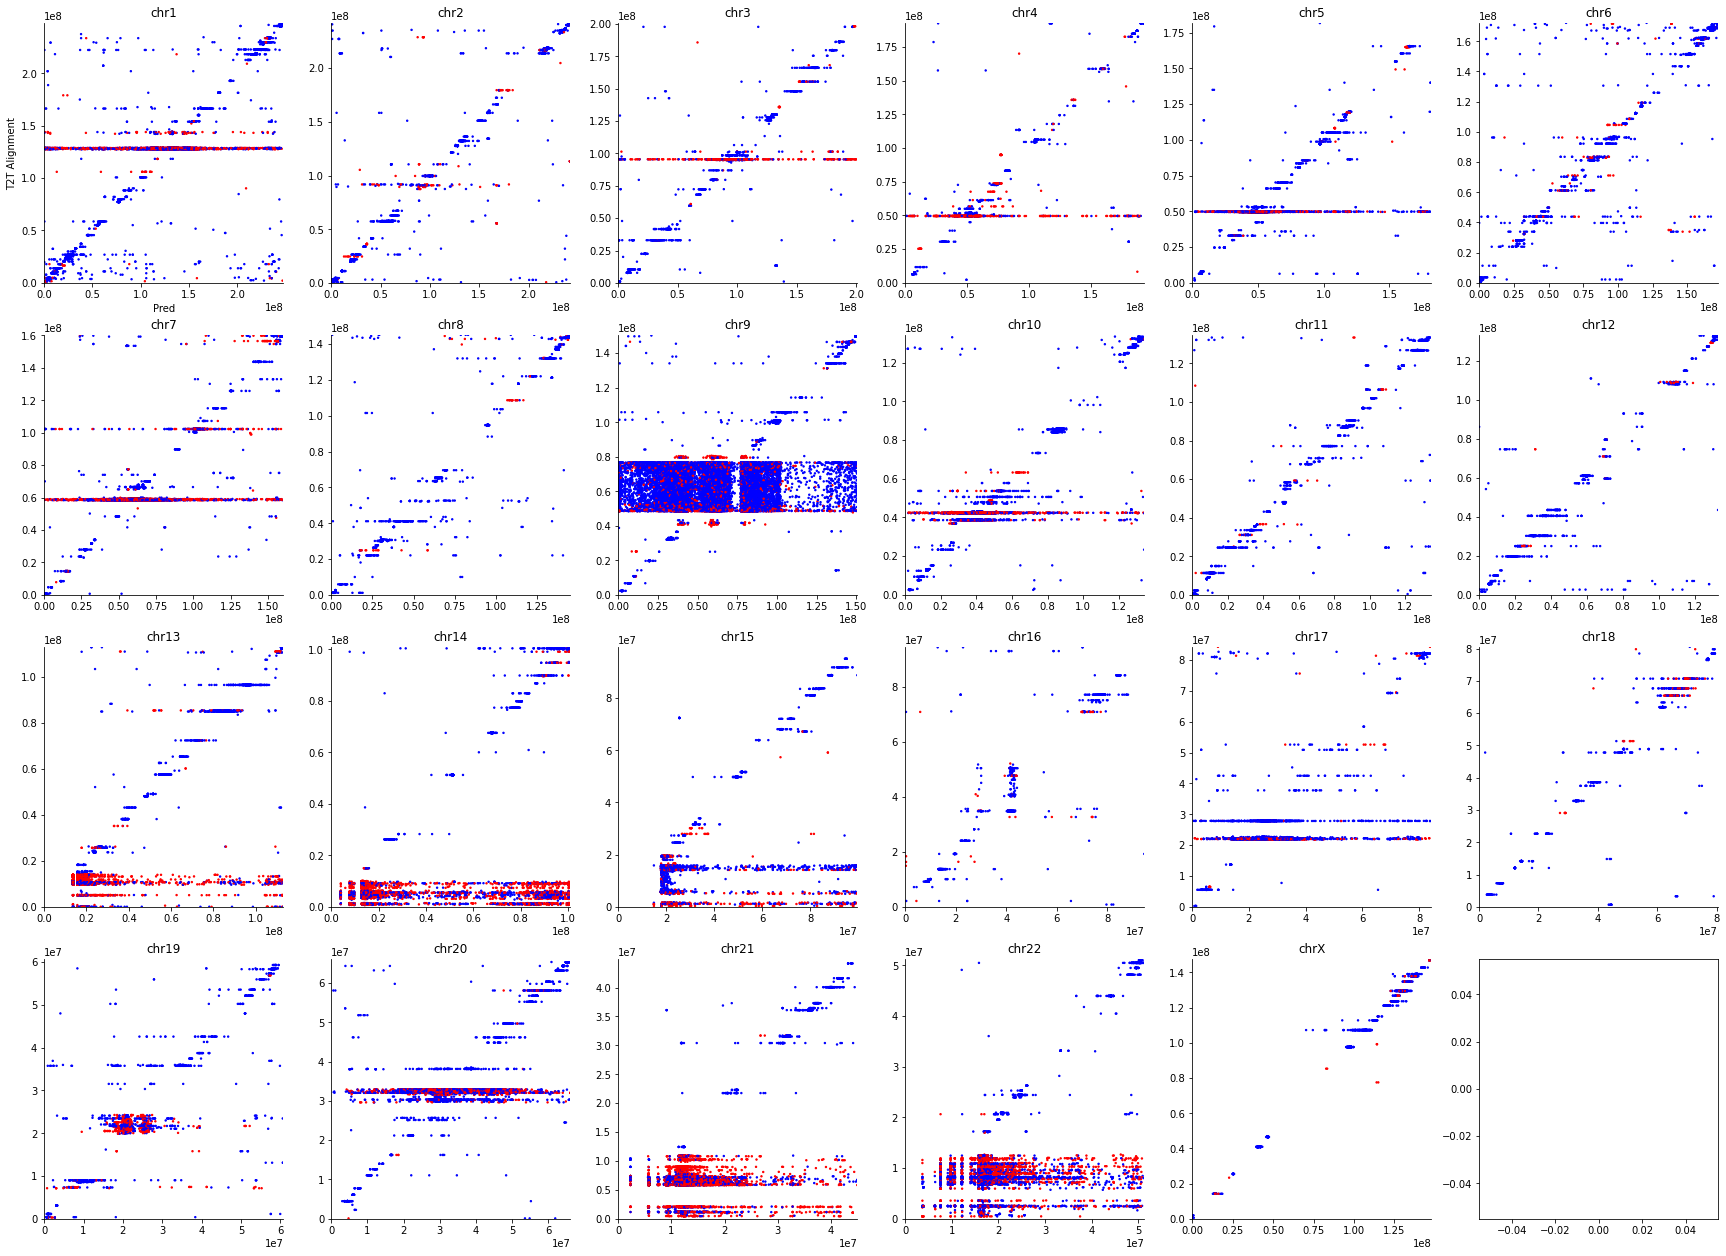

In [34]:
file_dir='/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/localized_vs_aligned_colored_by_multAlignment.svg'
def color_by_mult_alignment(ax, loci_localized,loci_aligned, current_slice):
    ax.scatter(loci_localized, loci_aligned, c=current_slice['mult_alignments'], s=2, alpha=1, cmap='bwr', vmin=0, vmax=1)

MakeComparisonPlot(plot_function=color_by_mult_alignment, file_dir=file_dir)

# Genetic Diversity

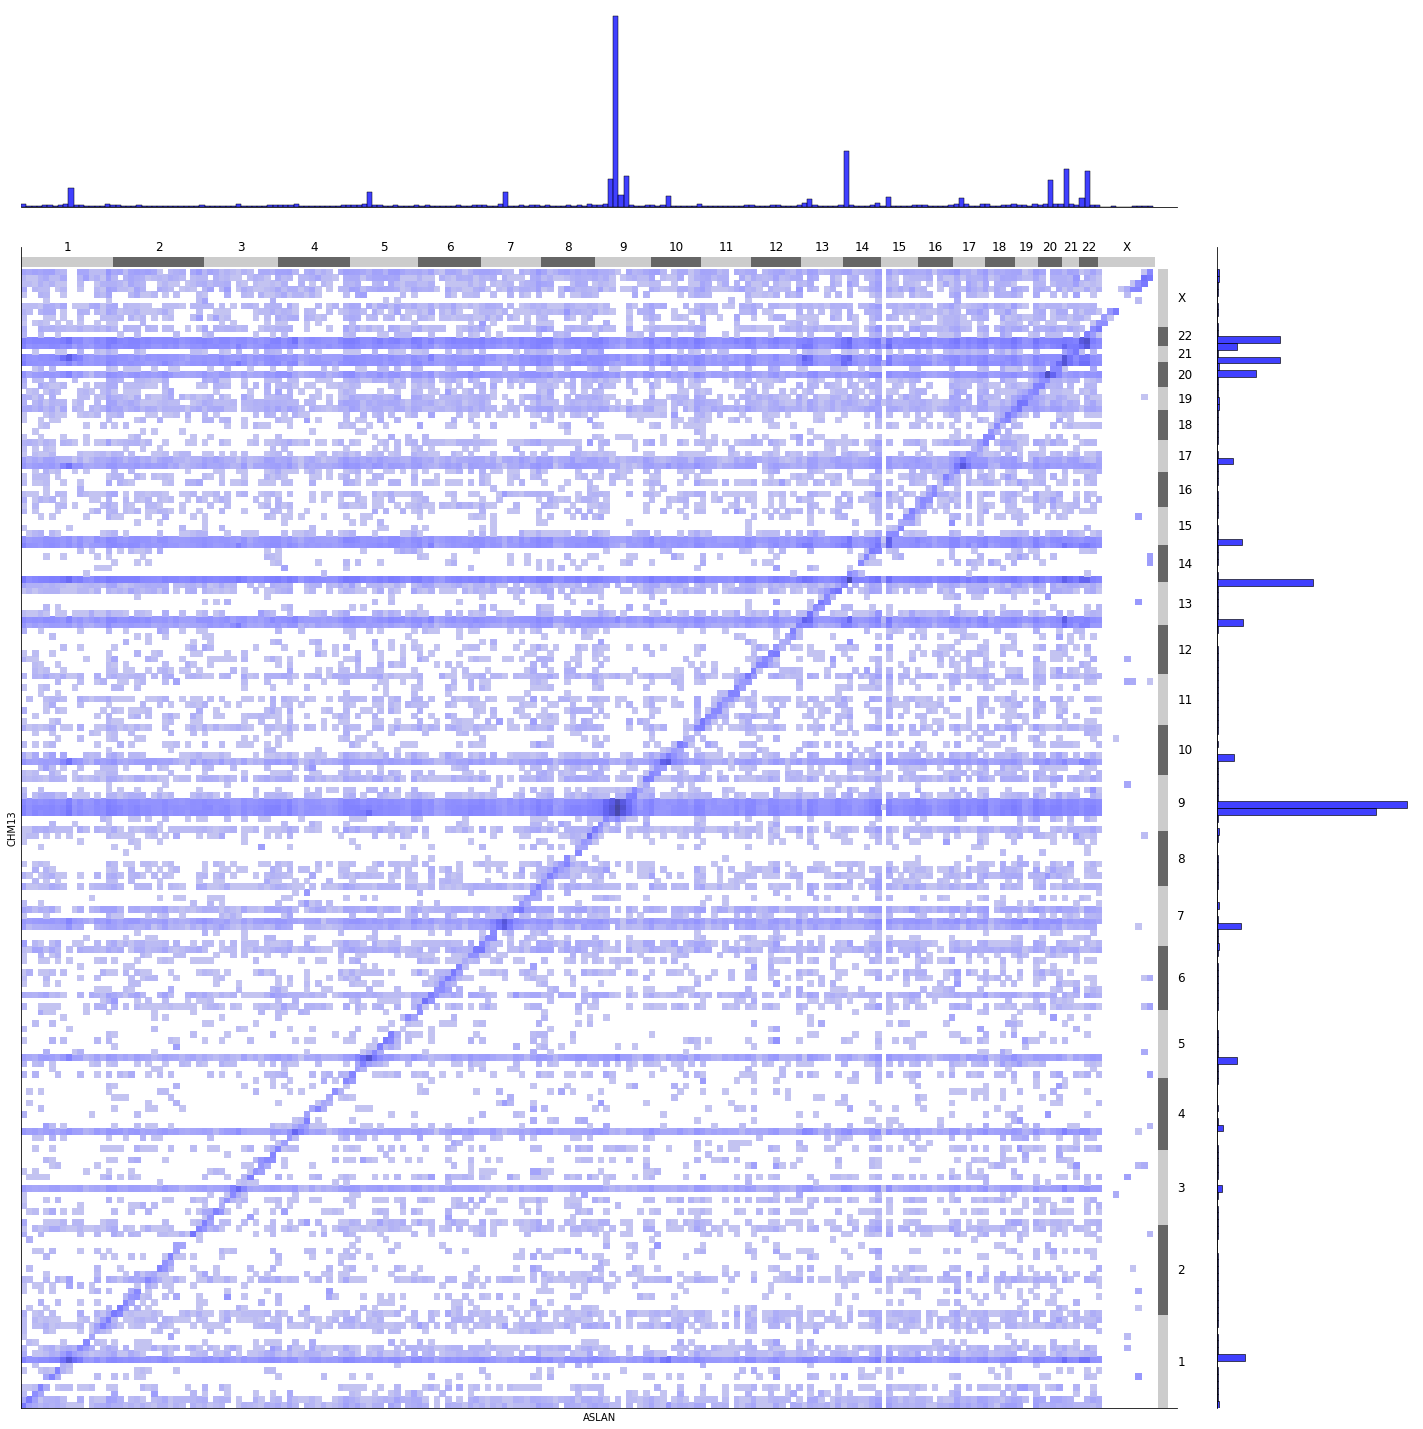

array([[1.        , 0.50030628],
       [0.50030628, 1.        ]])

In [30]:
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

#f, ax = plt.subplots(figsize=(20,20))
if False:
    for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
        r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                      height=3047968796, width=stop-start, color='grey', alpha=.5)
        r1 = Rectangle(xy=(0,loci_linear_idx(chrom.replace('chr', ''), start)),
                    width=3047968796, height=stop-start, color='grey', alpha=.5)
        ax.add_patch(r)
        ax.add_patch(r1)
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

localized =[loci_linear_idx(chrom.replace('X','23').replace('M','24'),start) for chrom,start in zip(comparison['chrom_localized'],
                                                             (comparison['start_localized']+comparison['end_localized'])/2)]
aligned =[loci_linear_idx(chrom.replace('X','23').replace('M','24'),start) for chrom,start in zip(comparison['chrom_aligned'],
                                                             comparison['start_aligned'])]
jp = sns.jointplot(x=localized,y=aligned, kind='hist', norm=LogNorm(), bins=200, height=20, vmin=None, vmax=None, color='blue')
#plt.xlabel('localization algorithm')
#plt.ylabel('T2T Alignment')
jp.ax_joint.set_xticks([])
jp.ax_joint.set_yticks([])

# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=starts_chrom[23]+5e7, s=chrom, fontsize=12, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=starts_chrom[23]+2e7, color=color, linestyle='-', linewidth=10)
    
    plt.text(y=np.mean(starts_chrom[i:i+2]), x=starts_chrom[23]+6e7, s=chrom, fontsize=12, va='center', ha='left')#, rotation=45, va='top', ha='right')
    plt.vlines(ymin=starts_chrom[i], ymax=starts_chrom[i+1], x=starts_chrom[23]+2e7, color=color, linestyle='-', linewidth=10)



plt.xlim(-1,starts_chrom[23]+6e7)
plt.ylim(-1,starts_chrom[23]+6e7)
plt.xlabel('ASLAN')
plt.ylabel('CHM13')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_comparison/comparison_t2t_location.svg', transparent=True)
plt.show()
np.corrcoef(localized, aligned)

#plt.xlabel('localized')
#plt.aligend('localized')

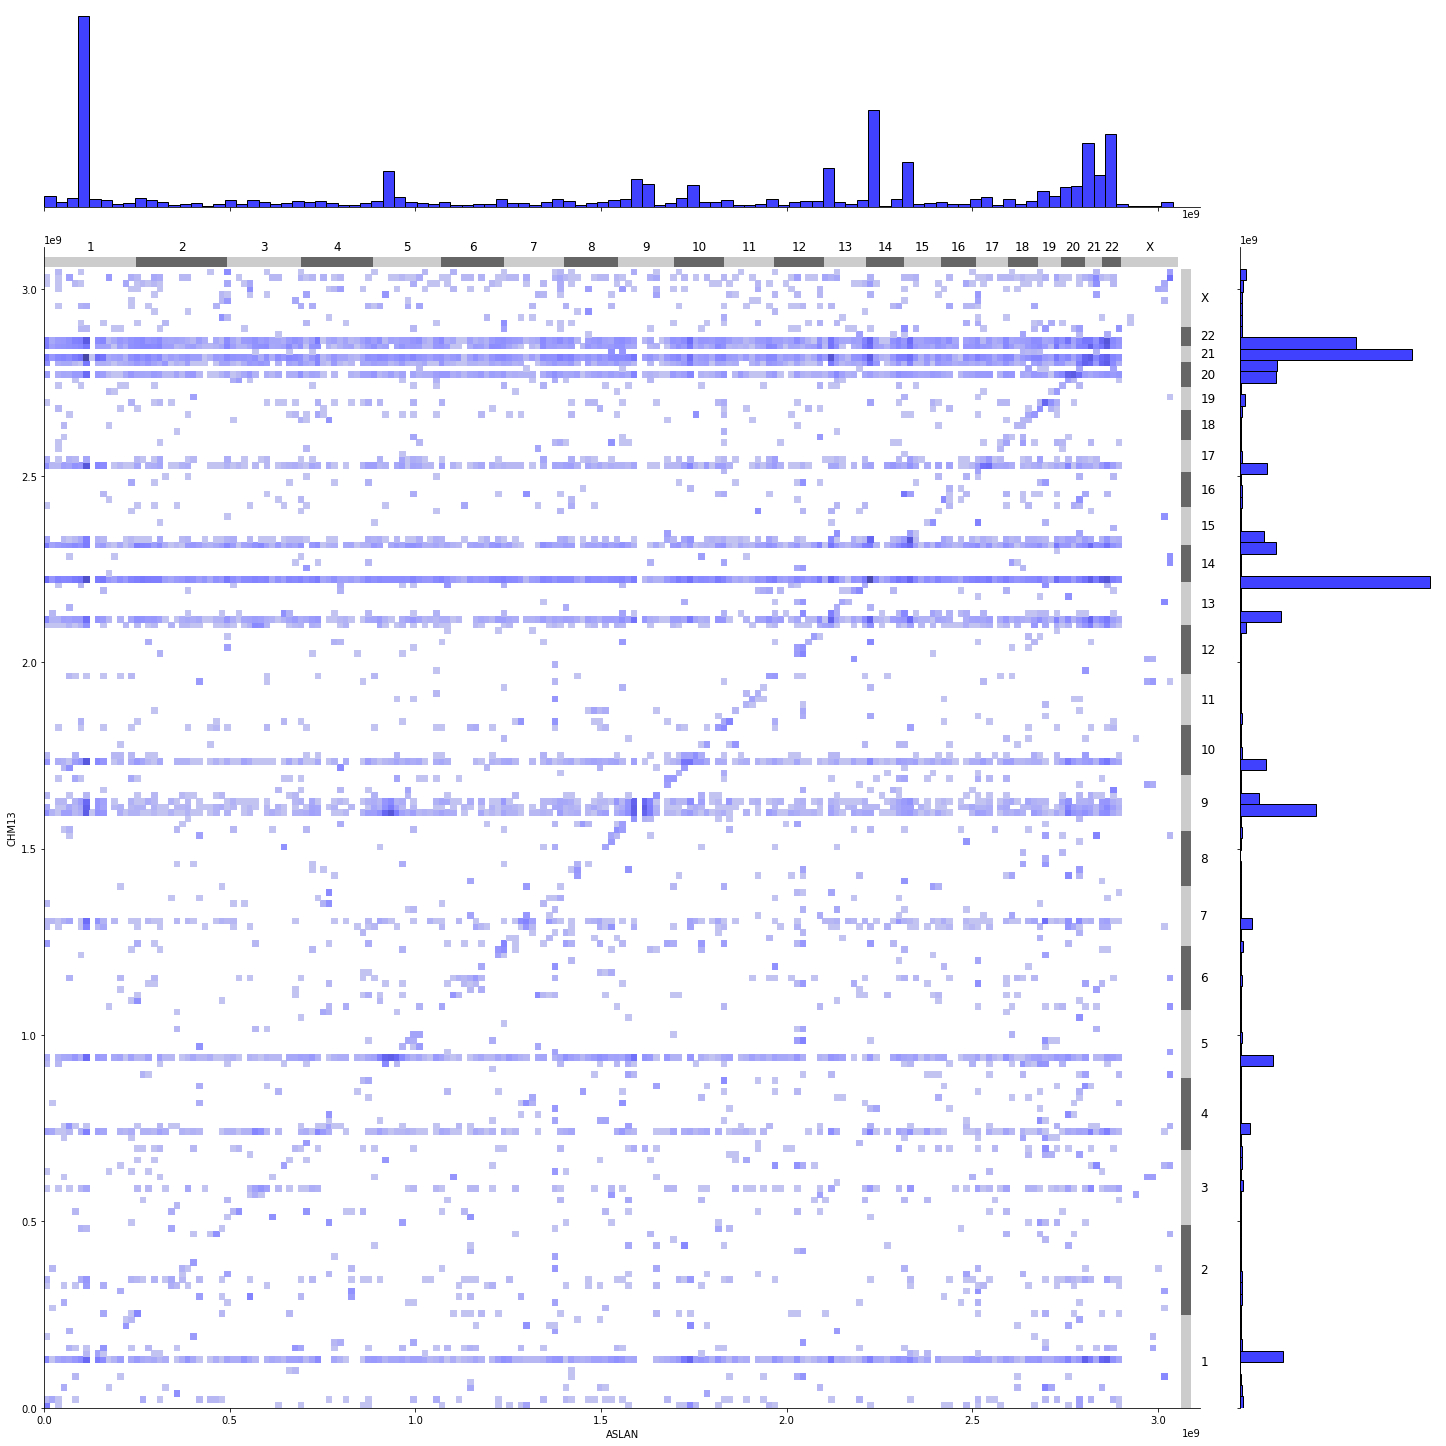

In [32]:
# Places with genetic diversity not captured on the T2T
#f, ax = plt.subplots(figsize=(10,10))
A = comparison[(~comparison.loci_correct) & (comparison.AS<90)]
p = sns.jointplot(y=[loci_linear_idx(chrom.replace('X', '23').replace('M', '24'), loci) for chrom, loci in zip(A.chrom_aligned, A.start_aligned)], 
              x=[loci_linear_idx(chrom.replace('X', '23').replace('M', '24'), loci) for chrom, loci in zip(A.chrom_localized, A.start_localized)],
              kind='hist', norm=LogNorm(), vmin=None, vmax=None, bins=200, marginal_kws=dict(bins=100), height=20, color='blue')
# PUT IN CHROMSOME STUFF
for i in range(23):
    if i%2==0: color=(.8,.8,.8)
    else: color=(.4,.4,.4)
    chrom=str(i+1)
    if chrom=='23': chrom='X'
    plt.text(x=np.mean(starts_chrom[i:i+2]), y=starts_chrom[23]+5e7, s=chrom, fontsize=12, ha='center')#, rotation=45, va='top', ha='right')
    plt.hlines(xmin=starts_chrom[i], xmax=starts_chrom[i+1], y=starts_chrom[23]+2e7, color=color, linestyle='-', linewidth=10)
    
    plt.text(y=np.mean(starts_chrom[i:i+2]), x=starts_chrom[23]+6e7, s=chrom, fontsize=12, va='center', ha='left')#, rotation=45, va='top', ha='right')
    plt.vlines(ymin=starts_chrom[i], ymax=starts_chrom[i+1], x=starts_chrom[23]+2e7, color=color, linestyle='-', linewidth=10)


plt.xlim(-1,starts_chrom[23]+6e7)
plt.ylim(-1,starts_chrom[23]+6e7)
plt.xlabel('ASLAN')
plt.ylabel('CHM13')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/t2t_genetic_variation/disagreement_low_AS_joint.svg', transparent=True)
plt.show()

In [ ]:
# Places with genetic diversity not captured on the T2T
f, ax = plt.subplots(figsize=(20,3))
plt.hist([loci_linear_idx(int(chrom.replace('chr', '').replace('X', '23')), loci) for chrom, loci in zip(
    localized_but_not_aligned.chrom, 
    (localized_but_not_aligned.start+localized_but_not_aligned.end)/2)], bins=1000)
ax.set_title('Reads localized but not aligned')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(0,starts_chrom[23]-1)

#plt.savefig('')

# Printing some metrics

------------

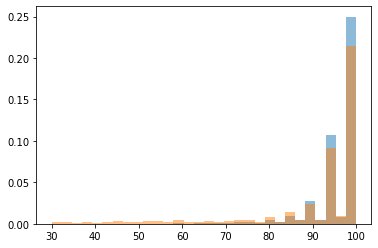

frac with alt mapping
0.27506578422773303
0.41992109579325326
frac with new loc in T2T


KeyError: 'is_new_loc'

In [166]:
plt.hist(comparison[comparison.chrom_localized==comparison.chrom_aligned]['AS'], alpha=.5, density=True,bins=30)
plt.hist(comparison[comparison.chrom_localized!=comparison.chrom_aligned]['AS'], alpha=.5, density=True,bins=30)
plt.show()
print('frac with alt mapping')
print(np.mean(comparison[comparison.chrom_localized==comparison.chrom_aligned]['mult_alignments']))
print(np.mean(comparison[comparison.chrom_localized!=comparison.chrom_aligned]['mult_alignments']))

print('frac with new loc in T2T')
print(np.mean(comparison[comparison.chrom_localized==comparison.chrom_aligned]['is_new_loc']))
print(np.mean(comparison[comparison.chrom_localized!=comparison.chrom_aligned]['is_new_loc']))

In [170]:
comparison_filt = comparison[(comparison['AS']==100) & (~comparison['mult_alignments'])]
print(np.mean(comparison_filt.is_same_chrom))
print(np.mean(comparison_filt.is_same_loc))

0.7934636118598383
0.44036388140161725


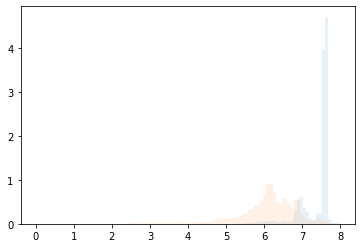

In [171]:
plt.hist(np.log10(comparison[comparison.is_same_loc]['end_localized']-comparison[comparison.is_same_loc]['start_localized']),
         alpha=.1, density=True, bins=np.linspace(0,8,100))
plt.hist(np.log10(comparison[~comparison.is_same_loc]['end_localized']-comparison[~comparison.is_same_loc]['start_localized']),
         alpha=.1, density=True, bins=np.linspace(0,8,100))
plt.show()

In [172]:
print(np.median(comparison[comparison.is_same_loc]['end_localized']-comparison[comparison.is_same_loc]['start_localized']))
print(np.median(comparison_filt[comparison_filt.is_same_loc]['end_localized']-comparison_filt[comparison_filt.is_same_loc]['start_localized']))

38900674.0
39144695.0


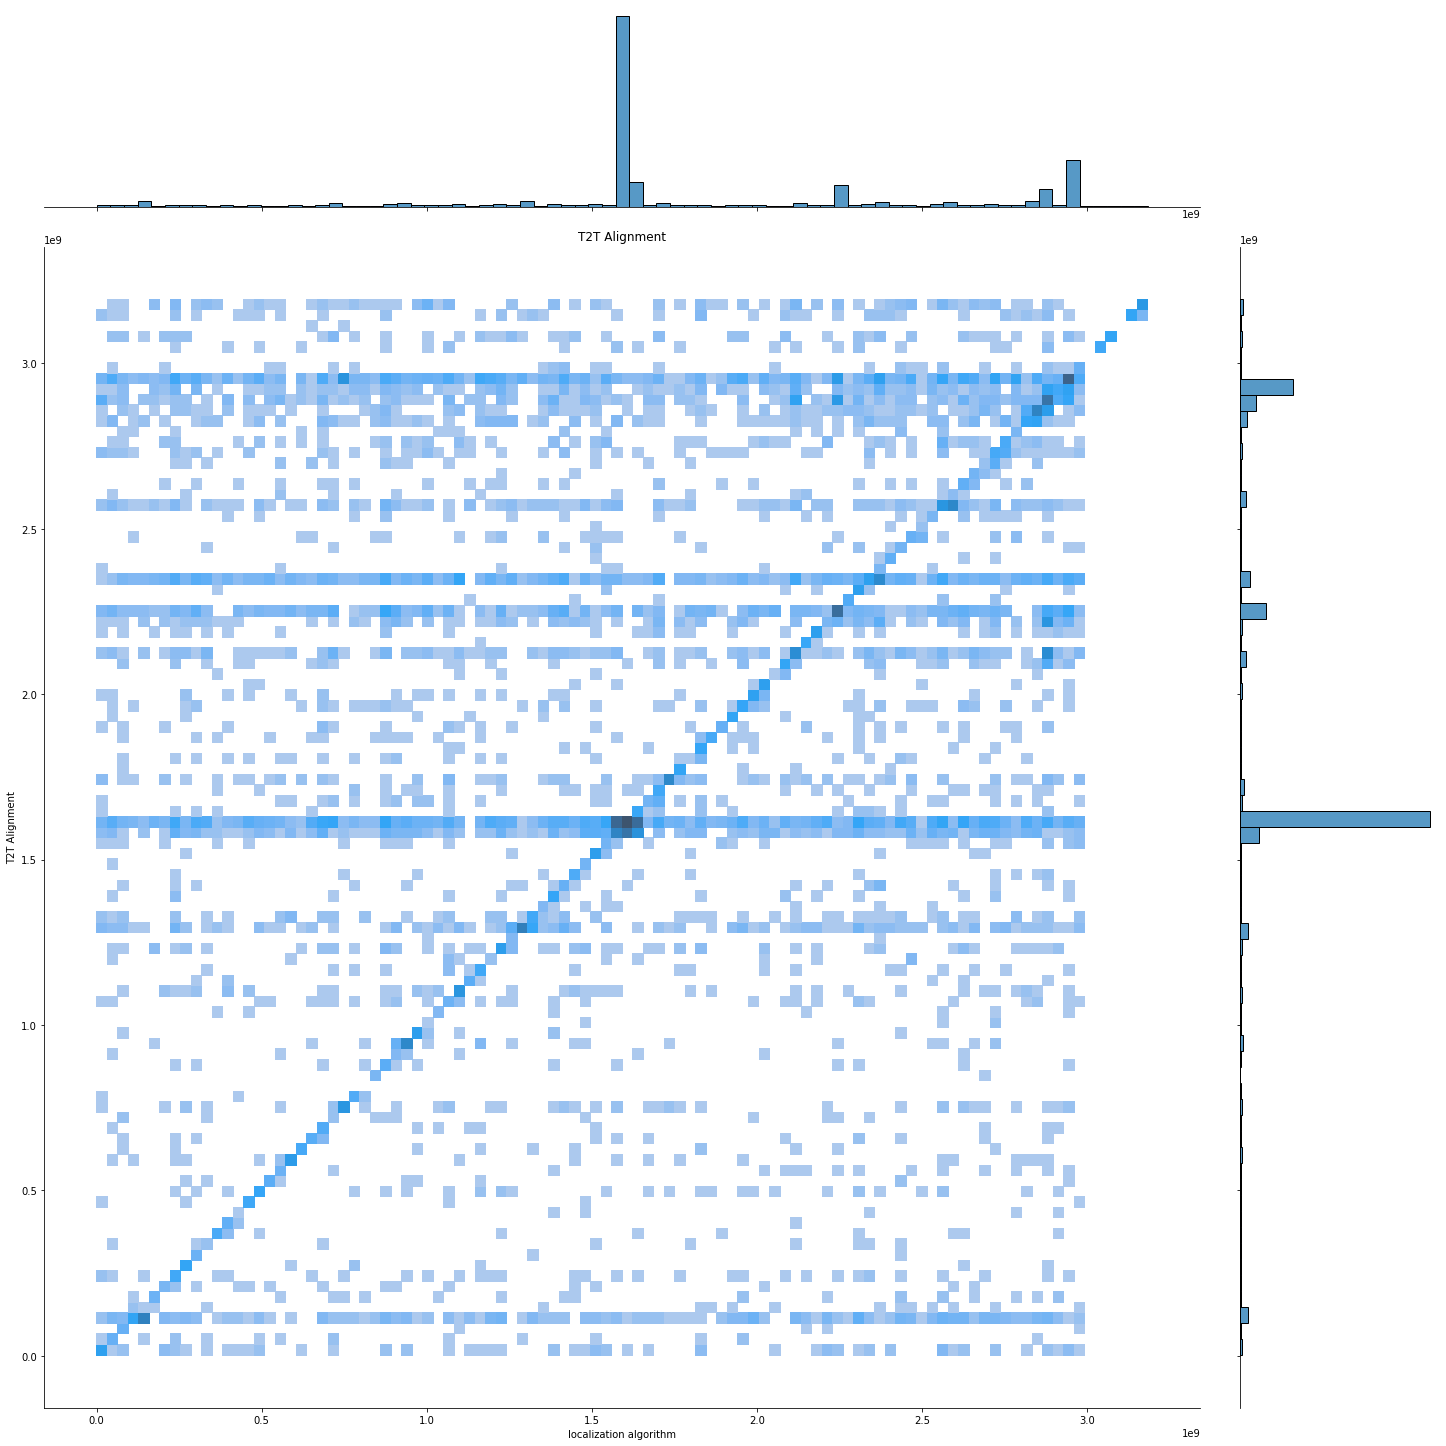

array([[1.        , 0.62485921],
       [0.62485921, 1.        ]])

In [173]:
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

#f, ax = plt.subplots(figsize=(20,20))
if False:
    for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
        r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                      height=3047968796, width=stop-start, color='grey', alpha=.5)
        r1 = Rectangle(xy=(0,loci_linear_idx(chrom.replace('chr', ''), start)),
                    width=3047968796, height=stop-start, color='grey', alpha=.5)
        ax.add_patch(r)
        ax.add_patch(r1)
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

localized =[loci_linear_idx(chrom.replace('X','24').replace('M','24'),start) for chrom,start in zip(comparison_filt['chrom_localized'],
                                                             (comparison_filt['start_localized']+comparison_filt['end_localized'])/2)]
aligned =[loci_linear_idx(chrom.replace('X','24').replace('M','24'),start) for chrom,start in zip(comparison_filt['chrom_aligned'],
                                                             comparison_filt['start_aligned'])]
jp = sns.jointplot(x=localized,y=aligned, kind='hist', norm=LogNorm(), bins=100, height=20, vmin=None, vmax=None)
plt.xlabel('localization algorithm')
plt.ylabel('T2T Alignment')
#plt.spines['top'].set_visible(False)
#plt.spines['right'].set_visible(False)
plt.title('T2T Alignment')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/comparison_t2t_location_filt.svg', transparent=True)
plt.show()
np.corrcoef(localized, aligned)
#plt.xlabel('localized')
#plt.aligend('localized')

/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


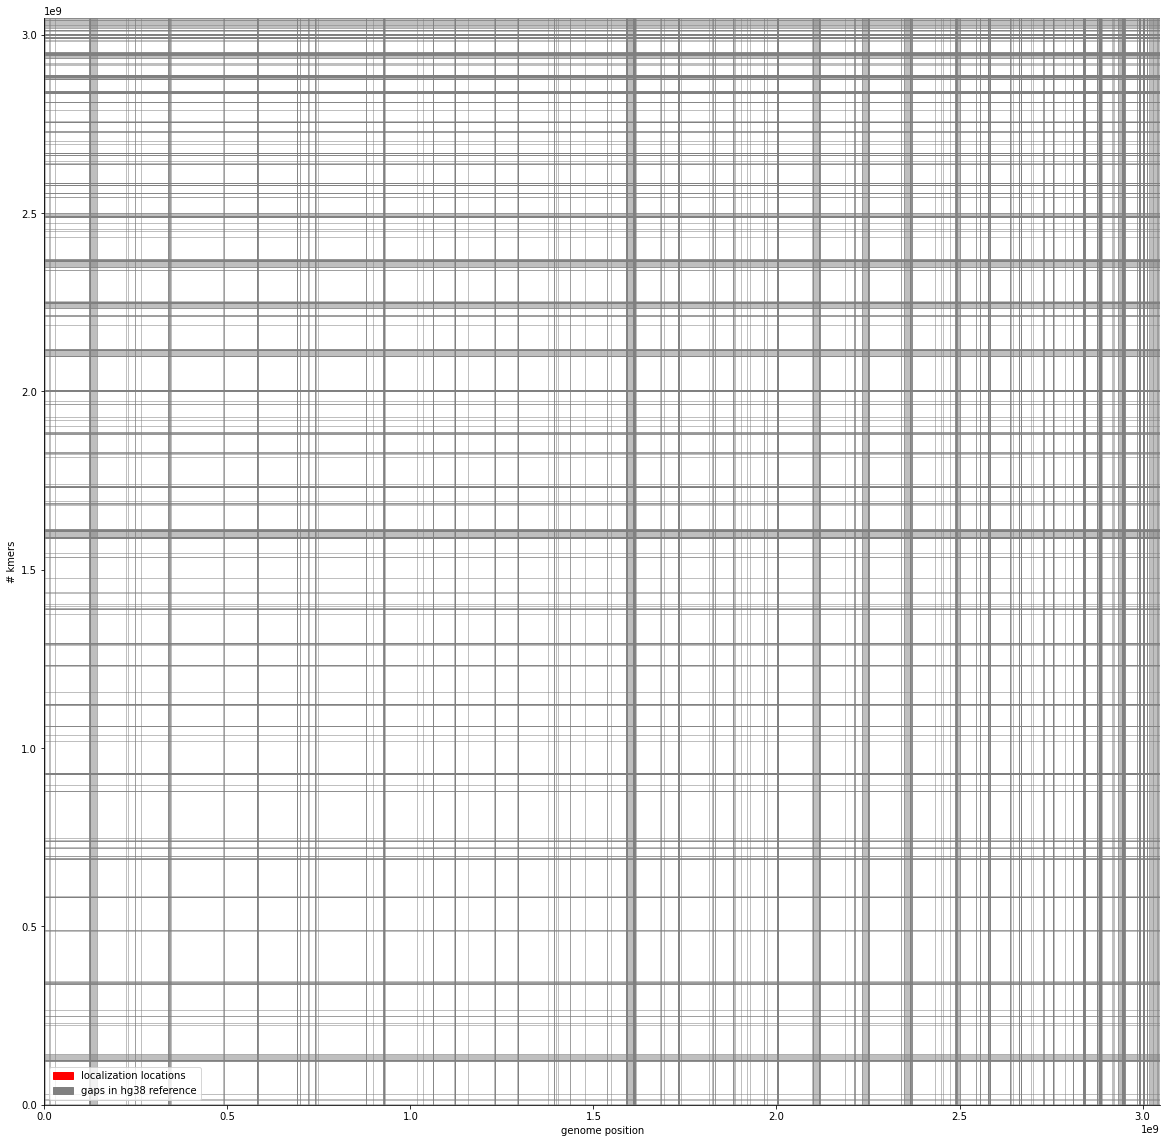

In [46]:
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

f, ax = plt.subplots(figsize=(20,20))

for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
    r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                  height=3047968796, width=stop-start, color='grey', alpha=.5)
    r1 = Rectangle(xy=(0,loci_linear_idx(chrom.replace('chr', ''), start)),
                width=3047968796, height=stop-start, color='grey', alpha=.5)
    ax.add_patch(r)
    ax.add_patch(r1)
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

#p = plt.hist(linear_locs, bins=10000, color='r')
plt.legend([red_patch, grey_patch], ['localization locations', 'gaps in hg38 reference'])
plt.xlim(0,loci_linear_idx(chrom.replace('chr', ''), stop))
plt.ylim(0,loci_linear_idx(chrom.replace('chr', ''), stop))
#plt.yscale('symlog', linthresh=1000)
plt.ylabel('# kmers')
plt.xlabel('genome position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
plt.show()



In [55]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
print(sum(gaps_df['type']=='N'))
gaps_t2t_aligned = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/gaps_hg38_t2t_aligned_starts.bed', header=None)
gaps_t2t_aligned.index = gaps_t2t_aligned[3]
gaps_df = gaps_df.loc[gaps_t2t_aligned.index]
gaps_df

819


,chrom,start,stop,idx,type,ncbi_idx,location,7,8
3,,,,,,,,,
2,chr1,10616,177417,3,F,AL627309.15,103,166904,+
12,chr1,835051,835333,13,O,KF495845.1,1,283,-
13,chr1,835334,871977,14,F,AL669831.13,137797,174440,+
14,chr1,871978,872551,15,O,KF454898.1,1,574,+
15,chr1,872552,877104,16,F,AL669831.13,175015,179567,+
...,...,...,...,...,...,...,...,...,...
395,chr1,23528238,23528514,396,O,KF495899.1,1,277,+
396,chr1,23528515,23540092,397,F,AL021154.1,78280,89857,+
397,chr1,23540093,23540321,398,O,KF510726.1,1,229,-


In [56]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df[gaps_df[4]=='N'].head(10)

,0,1,2,3,4,5,6,7,8
0,chr1,1,10000,1,N,10000,telomere,no,na
4,chr1,207667,257666,5,N,50000,contig,no,na
6,chr1,297969,347968,7,N,50000,contig,no,na
9,chr1,535989,585988,10,N,50000,contig,no,na
47,chr1,2702782,2746290,48,N,43509,scaffold,yes,unspecified
223,chr1,12954385,13004384,224,N,50000,scaffold,yes,clone_contig
276,chr1,16799164,16849163,277,N,50000,scaffold,yes,unspecified
490,chr1,29552234,29553835,491,N,1602,scaffold,yes,paired-ends
1844,chr1,121976460,122026459,1845,N,50000,contig,no,na
1846,chr1,122224536,122224635,1847,N,100,contig,no,na


In [57]:
#t2t_alignment_in_hg38_coords_unmapped = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_unmapped.bed', nrows=1000)
#t2t_alignment_in_hg38_coords = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_hg38.bed', nrows=10000, header=None)
#t2t_alignment_in_hg38_coords.index = t2t_alignment_in_hg38_coords[3]
t2t_alignment_in_t2t_coords = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_1v1.bed',
                                            nrows=1000000, header=None)
#t2t_alignment_in_t2t_coords = t2t_alignment_in_t2t_coords[t2t_alignment_in_t2t_coords[0]=='chr1']


In [ ]:
len(gaps_t2t_aligned)

In [60]:
sum(gaps_df['type']=='N')

819

In [16]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
#gaps_df = gaps_df[gaps_df.type=='N']

In [ ]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[gaps_df.type=='N']

f, ax = plt.subplots(figsize=(20,3))
localized = localized[~np.isnan(localized.chrom_pred)]
linear_locs = [loci_linear_idx(chrom_pred, start_pred) for chrom_pred, start_pred in zip(localized.chrom_pred, localized.start_pred)]
nbins = plt.hist(linear_locs, bins=1000, color='r')
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df = gaps_df[gaps_df.type=='N']
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

f, ax = plt.subplots(figsize=(20,3))

for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
    r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                  height=1.1*max(nbins[0]), width=stop-start, color='grey', alpha=.1)
    ax.add_patch(r)
    
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

p = plt.hist(linear_locs, bins=10000, color='r')
plt.legend([red_patch, grey_patch], ['localization locations', 'gaps in hg38 reference'])
#plt.xlim(0,stop)
plt.yscale('symlog', linthresh=1000)
plt.ylabel('# kmers')
plt.xlabel('genome position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
plt.show()



In [7]:
import pysam
bed = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_1v1.bed', nrows=10000, header=None)

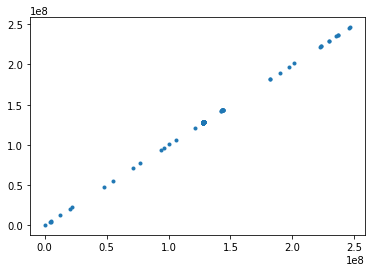

In [12]:
i = 1
loci = bed[bed[0]=='chr%i' % i][1]
plt.plot(loci, loci, '.')

In [67]:
samfile = pysam.AlignmentFile("/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_small.sam", "r")
metrics = [(x.reference_name, x.reference_start,
                  True if 'XA' in [i[0] for i in x.get_tags()] else False,
                   x.get_tag('AS'))
                  for x in samfile.fetch()]

NameError: name 'pysam' is not defined

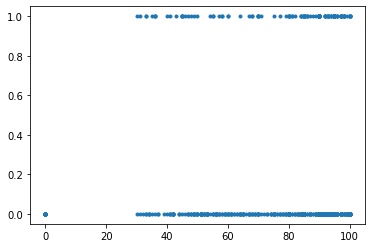

In [116]:
metrics_df = pd.DataFrame(metrics)
metrics_df[pd.isnull(metrics_df)] = np.nan
plt.plot(metrics_df[3], metrics_df[2], '.')

(array([ 99.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   1.,
          4.,   3.,   2.,   4.,   2.,   0.,   1.,   2.,   4.,   6.,   1.,
          2.,   5.,   2.,   4.,   4.,   6.,   6.,   9.,   4.,   8.,   2.,
          5.,   7.,   4.,   4.,   4.,   6.,   4.,   2.,   2.,   6.,   5.,
          1.,   5.,   5.,   3.,   9.,   2.,   1.,   2.,   3.,   8.,   2.,
          4.,   3.,   5.,  27.,   4.,   4.,   5.,  13.,  33.,   5.,   7.,
          3.,  10., 113.,  13.,  17.,  16.,  14., 338.,  12.,  16.,  10.,
         28.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  4

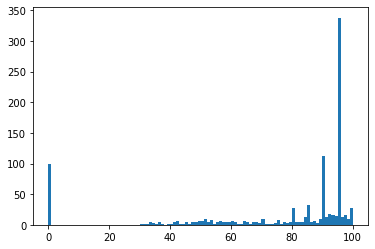

In [129]:
plt.hist(metrics_df[3], bins=100)

In [47]:
print(x.query_sequence)
print(x.get_reference_sequence())
print(np.array([i for i in x.query_sequence])==np.array([i for i in x.get_reference_sequence()]))

ATTCGATGCCATTCGATTCCTTTCTATTCGATTCCATTCAATTCCATTCGATTACCTTTTGTCCATTCTATTCCATTCGATTAAATTCAATTCCATTCTA
ATTCGATGCCATTCGATTCCTTTCTATTCGATTCCATTCAATTCCATTCGATTACCTTTTGTCCATTCTATTCCATTCGATTAAATTCAATTCCATTCgA
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True]


In [41]:
len(x.get_reference_sequence())

81

In [18]:
np.array(x.query_sequence)

array('ATATATGTAATATGTTGTATGTATAATGCATATATTAAATATATATGATATGTCTACGTTATTAATTATATGTAATATATGTTATATATTATATATTTTA',
      dtype='<U100')

In [12]:
x.get_reference_sequence()

'ATATATGTAATAcGTTGTATGTATAATGCATATATTAAATATATATGATATGTCTACGTTATTAATTATATGTAATATATGTTATATATTATATATTTTA'

In [5]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')

# Seeing which k-mers are in T2T assembly.

In [6]:
t2t_kmers = np.load('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/t2t_kmers_19.npy', allow_pickle=True).item()

In [7]:
unmapped_seqs = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_prev_and_median_filt.txt', 
                 nrows=1000, header=None)[0].values

In [ ]:
seqs_on_chrom = [[] for _ in unmapped_seqs]

for chrom in range(19,23):
    print(chrom)
    t2t_kmers = np.load('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/t2t_kmers_%i.npy' % chrom, allow_pickle=True).item()
    for i,s in enumerate(unmapped_seqs):
        complement = s.replace('A', 't').replace('T', 'a').replace('G', 'c').replace('C', 'g').replace(
            'a', 'A').replace('t', 'T').replace('c', 'C').replace('g', 'G')
        for seq_string in [s, s[::-1], complement, complement[::-1]]:
            if seq_string in t2t_kmers: 
                seqs_on_chrom[i] = seqs_on_chrom[i] + [t2t_kmers[seq_string]]

19
20
21
22


In [10]:
# 20% of sequences were found on the chromsome.
np.mean(seqs_on_chrom[localized[localized[2]==20.0].index]==20)

NameError: name 'localized' is not defined

In [342]:
# Percentage of sequences localized correctly according to 
Counter(localized[2][seqs_on_chrom==20.0])[20.0]/sum(Counter(localized[2][seqs_on_chrom==20.0]).values())

0.6991951710261569

In [271]:
males_mean = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='1.0')[0])]).apply(lambda x: np.mean(x[x>0]),axis=1)

females_mean = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='2.0')[0])]).apply(lambda x: np.mean(x[x>0]),axis=1)

males_prev = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='1.0')[0])]>0).mean(axis=1)

females_prev = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='2.0')[0])]>0).mean(axis=1)

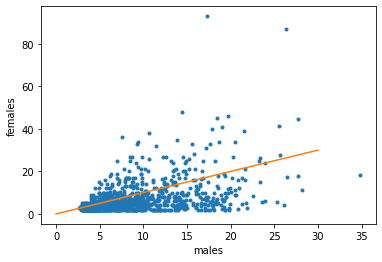

In [272]:
plt.plot(males_mean, females_mean, '.')
plt.xlabel('males')
plt.ylabel('females')
plt.plot([0,30], [0,30])
plt.show()

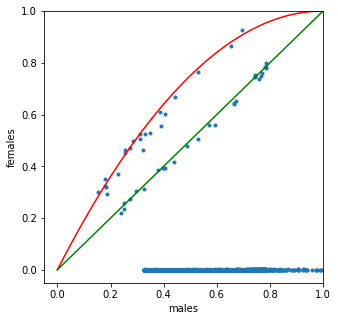

In [274]:
plt.figure(figsize=(5,5))
plt.plot(males_prev, females_prev, '.')
plt.xlabel('males')
plt.ylabel('females')
plt.xlim(-.05,1)
plt.ylim(-.05,1)
mp = np.linspace(0,1, 100)
fp_predicted = (1-(1-mp)*(1-mp))
plt.plot(mp, fp_predicted, 'r-')
plt.plot([0,1], [0,1], 'g-')


In [71]:
for s in unmapped_seqs[:100]:
    complement = s.replace('A', 't').replace('T', 'a').replace('G', 'c').replace('C', 'g').replace(
        'a', 'A').replace('t', 'T').replace('c', 'C').replace('g', 'G')
    print(human_genome.count(s), human_genome.count(complement), 
          human_genome.count(s[::-1]), human_genome.count(complement[::-1]))

0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


KeyboardInterrupt: 

In [ ]:
c = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.tsv', nrows=10000)
Counter([tuple(a[1]) for a in df[['chrom_pred']].iterrows()]).most_common()

In [ ]:
s = unmapped_seqs[6]
complement = s.replace('A', 't').replace('T', 'a').replace('G', 'c').replace('C', 'g').replace(
        'a', 'A').replace('t', 'T').replace('c', 'C').replace('g', 'G')
#human_genome.count(complement[::-1])
[(r.id, str(r.seq).find(complement[::-1])) for r in records]# for r in records]

In [62]:
np.cumsum([len(r) for r in records])

array([ 248387328,  491084080,  692190028,  885764973, 1067810412,
       1239937040, 1400504468, 1546763799, 1697381046, 1832139180,
       1967266949, 2100591497, 2214158183, 2315319675, 2415072870,
       2511403244, 2595680141, 2676222679, 2737930043, 2804140298,
       2849230980, 2900555906, 3054815472, 3054832041])

In [257]:
np.mean(df.chrom_pred==23.0)

0.1584

NameError: name 'kmers' is not defined